In [1]:
# importing some basic libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('always')
filename = 'cat1.csv'
file = pd.read_csv(filename,index_col=0)
print(file.shape)

(649, 38)


In [16]:
class SVM(object):
    def __init__(self,visualization=True):
        self.visualization = visualization
        #self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    
    def fit(self,data):
        #train with data
        self.data = data
        # { |\w\|:{w,b}}
        opt_dict = {}
        
        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
        
        all_data = np.array([])
        for yi in self.data:
            all_data = np.append(all_data,self.data[yi])
                    
        self.max_feature_value = max(all_data)         
        self.min_feature_value = min(all_data)
        all_data = None
        
        #with smaller steps our margins and db will be more precise
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      #point of expense
                      self.max_feature_value * 0.001,]
        
        #extremly expensise
        b_range_multiple = 5
        #we dont need to take as small step as w
        b_multiple = 5
        
        latest_optimum = self.max_feature_value*10
        
        """
        objective is to satisfy yi(x.w)+b>=1 for all training dataset such that ||w|| is minimum
        for this we will start with random w, and try to satisfy it with making b bigger and bigger
        """
        #making step smaller and smaller to get precise value
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            
            #we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*self.max_feature_value*b_range_multiple,
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        
                        #weakest link in SVM fundamentally
                        #SMO attempts to fix this a bit
                        # ti(xi.w+b) >=1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b)>=1:
                                    found_option=False
                        if found_option:
                            """
                            all points in dataset satisfy y(w.x)+b>=1 for this cuurent w_t, b
                            then put w,b in dict with ||w|| as key
                            """
                            opt_dict[np.linalg.norm(w_t)]=[w_t,b]
                
                #after w[0] or w[1]<0 then values of w starts repeating itself because of transformation
                #Think about it, it is easy
                #print(w,len(opt_dict)) Try printing to understand
                if w[0]<0:
                    optimized=True
                    print("optimized a step")
                else:
                    w = w-step
                    
            # sorting ||w|| to put the smallest ||w|| at poition 0 
            norms = sorted([n for n in opt_dict])
            #optimal values of w,b
            opt_choice = opt_dict[norms[0]]

            self.w=opt_choice[0]
            self.b=opt_choice[1]
            
            #start with new latest_optimum (initial values for w)
            latest_optimum = opt_choice[0][0]+step*2
    
    def predict(self,features):
        #sign(x.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification!=0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*',c=self.colors[classification])
        return (classification,np.dot(np.array(features),self.w)+self.b)

In [17]:
#l =['pred','galex_objid','sdss_objid','Unnamed: 0','spectrometric_redshift','Unnamed: 0.1']
#l =['class','pred','galex_objid','sdss_objid','Unnamed: 0.1','spectrometric_redshift','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z']
l =['class','pred','galex_objid','sdss_objid','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z']
X = file.drop(l,axis=1)
#y =file['spectrometric_redshift']
y = file['class']
for x in file['class']:
    if(x==0):
        x=-1
X.head()

,u,g,r,i,z,nuv_mag,fuv_mag,spectrometric_redshift,nuv-u,nuv-g,...,g-z,r-i,r-z,i-z,fuv-nuv,fuv-u,fuv-g,fuv-r,fuv-i,fuv-z
0,18.286291,16.968243,16.334318,16.039885,15.857203,20.535709,22.654970,0.001933,2.249418,3.567467,...,1.111040,0.294434,0.477116,0.182682,-2.119261,-4.368679,-5.686728,-6.320652,-6.615086,-6.797768
1,22.734962,21.516233,20.178501,19.238029,18.809675,22.594444,22.966053,2.097114,-0.140518,1.078211,...,2.706558,0.940472,1.368826,0.428354,-0.371609,-0.231091,-1.449820,-2.787552,-3.728024,-4.156378
2,21.223398,21.143623,21.149973,20.998989,21.145853,22.867874,24.001894,1.730619,1.644476,1.724251,...,-0.002230,0.150984,0.004120,-0.146864,-1.134020,-2.778496,-2.858271,-2.851921,-3.002905,-2.856041
3,21.771444,21.636995,21.564974,21.476393,21.266085,21.900541,22.846025,0.855979,0.129097,0.263546,...,0.370911,0.088581,0.298889,0.210308,-0.945484,-1.074581,-1.209030,-1.281052,-1.369633,-1.579941
4,22.767988,22.018591,21.658953,21.098751,20.734152,23.461775,24.284685,1.643224,0.693787,1.443184,...,1.284439,0.560202,0.924801,0.364599,-0.822910,-1.516697,-2.266094,-2.625732,-3.185934,-3.550533


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=1)
X_train_spectrometric_redshift = X_train['spectrometric_redshift']
X_test_spectrometric_redshift = X_test['spectrometric_redshift']
X_train=X_train.drop('spectrometric_redshift',axis=1)
X_test=X_test.drop('spectrometric_redshift',axis=1)
#y_test_spectrometric_redshift=y_test['spectrometric_redshift']
#y_train_spectrometric_resdhift=  y_train['spectrometric_redshift']
#X_test.shape
X_train_spectrometric_redshift.shape


(519,)

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

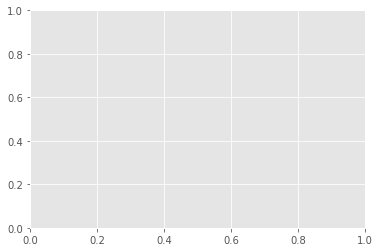

In [19]:
#dictionary=dict(zip(X_train,y_train))
svclassifier1 = SVM()
print(svclassifier1.fit(X_train))